In [148]:
import pygeostat as gs
from sdcalc import *
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [149]:
data = gs.DataFile('data/walker.dat', x='Xlocation in meter', y='Ylocation in meter')

In [150]:
sdcalc(data, 'Xlocation in meter', 'Ylocation in meter', None, 'T variable, indicator variable')

calculating signed distances for rock type 1
calculating signed distances for rock type 2


In [151]:
data.head()

,Identification Number,Xlocation in meter,Ylocation in meter,"V variable, concentration in ppm","U variable, concentration in ppm","T variable, indicator variable",signed_distances_rt_1,signed_distances_rt_2
0,1.0,11.0,8.0,0.0,NaN,2.0,168.433963,-168.433963
1,2.0,8.0,30.0,0.0,NaN,2.0,161.743624,-161.743624
2,3.0,9.0,48.0,224.4,NaN,2.0,145.890370,-145.890370
3,4.0,8.0,69.0,434.4,NaN,2.0,129.468143,-129.468143
4,5.0,9.0,90.0,412.1,NaN,2.0,113.137085,-113.137085


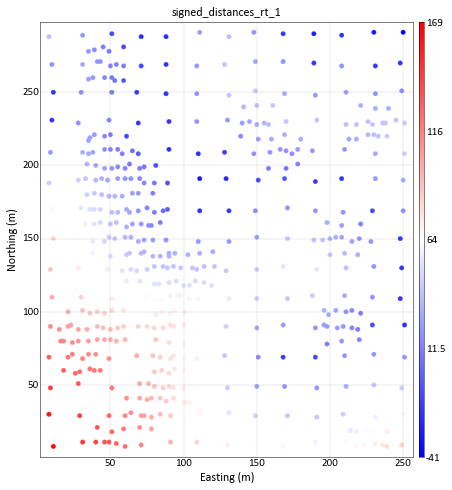

In [152]:
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr', grid=True)

In [153]:
grid = data.infergriddef(blksize=((3,3,0)))

In [154]:
grid

Pygeostat GridDef:
85 4.5 3.0 
98 4.5 3.0 
1 0.5 1.0

In [155]:
grid_coords = grid.get_coordinates()
data_coords = (data[data.x].values, data[data.y].values, np.ones(len(data))*0.5)

In [211]:
class RBF_PoU:
    def __init__(self, data_coords, grid_coords, D, nmax):
        self.D = D
        self.nmax = nmax
        self.data_coords = data_coords
        self.xp, self.yp, self.zp = self.data_coords[0], self.data_coords[1], self.data_coords[2]
        self.grid_coords = grid_coords
        self.xg, self.yg, self.zg = self.grid_coords[0], self.grid_coords[1], self.grid_coords[2]

        self.c_partition = None
        self.ul_partitions = []
        self.used_partitions = []
        self.grids_used = []
        self.uppers = []
        self.lowers = []

        self.weights = []
        self.acc_weights = np.zeros(len(self.xg))
        self.norm_weights = []

    def split(self):
        x, y, z = self.xp[self.c_partition], self.yp[self.c_partition], self.zp[self.c_partition]

        #Plotting for debug
        ###
        fig, axs = plt.subplots(1,1, figsize=(10,10))
        _ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)

        rect1 = Rectangle((np.min(x), np.min(y)), np.max(x)-np.min(x), np.max(y)-np.min(y), linewidth=1, edgecolor='red', facecolor='none')
        axs.add_patch(rect1)
        ###
        
        n = len(x)
        print('Number of samples in Pc: {}'.format(n))

        if n > self.nmax:
            npart = int(np.ceil(n/2*(1+self.D)))
            print('Number of samples in Pl and Pu: {}'.format(npart))
            deltax, deltay, deltaz = np.max(x)-np.min(x), np.max(y)-np.min(y), np.max(z)-np.min(z)
            longaxis = np.argmax([deltax, deltay, deltaz])
            sortedindices = np.argsort([x, y, z][longaxis])
            lpartidx, upartidx  = sortedindices[:npart], sortedindices[n-npart:]

            self.ul_partitions.append(self.c_partition[lpartidx])
            self.ul_partitions.append(self.c_partition[upartidx])

        else:
            print('Number of samples less than the treshold')
            self.used_partitions.append(self.c_partition)

            minx, maxx = np.min(x), np.max(x)
            miny, maxy = np.min(y), np.max(y)
            minz, maxz = np.min(z), np.max(z)
            self.lowers.append([minx, miny, minz])
            self.uppers.append([maxx, maxy, maxz])

            fx = np.logical_and(self.xg >= minx, self.xg <= maxx)
            fy = np.logical_and(self.yg >= miny, self.yg <= maxy)
            fz = np.logical_and(self.zg >= minz, self.zg <= maxz)
            fg = np.logical_and.reduce([fx, fy, fz])
            self.grids_used.append(fg)

            self.l_partition = None
            self.u_partition = None

    def partition(self):
        if self.c_partition is None:
            self.c_partition = np.arange(len(self.xp))
            self.split()
            
        while len(self.ul_partitions) > 0:
            self.c_partition = self.ul_partitions[0]
            self.split()       
            del self.ul_partitions[0]

    def calculate_weights(self):
        for i, idxs in enumerate(self.grids_used):
            coords = np.array(self.grid_coords).T[idxs]
            wlist = []
            ux, uy, uz = ups[i][0], ups[i][1], ups[i][2]
            lx, ly, lz = lows[i][0], lows[i][1], lows[i][2]
            for c in coords:
                xc, yc, zc = c[0], c[1], c[2]
                #dis = 1 - ((4 * (xc-lx) * (ux-xc)) / ((ux-lx)**2) * (4 * (yc-ly) * (uy-yc)) / ((uy-ly)**2) * (4 * (zc-lz) * (uz-zc)) / ((uz-lz)**2))
                dis = 1 - ((4 * (xc-lx) * (ux-xc)) / ((ux-lx)**2) * (4 * (yc-ly) * (uy-yc)) / ((uy-ly)**2))
                wlist.append(dis)
            
            dfunc = np.array(wlist)
            wfunc = 1 - dfunc

            self.weights.append(wfunc)
            self.acc_weights[idxs] = self.acc_weights[idxs] + wfunc

    def normalize_weights(self):
        for i, idx in enumerate(self.grids_used):
            nw = self.weights[i]/self.acc_weights[idx]
            self.norm_weights.append(nw)

In [242]:
ptest = RBF_PoU(data_coords=data_coords, grid_coords=grid_coords, D=0.25, nmax=100)

Number of samples in Pc: 470
Number of samples in Pl and Pu: 294
Number of samples in Pc: 294
Number of samples in Pl and Pu: 184
Number of samples in Pc: 294
Number of samples in Pl and Pu: 184
Number of samples in Pc: 184
Number of samples in Pl and Pu: 115
Number of samples in Pc: 184
Number of samples in Pl and Pu: 115
Number of samples in Pc: 184
Number of samples in Pl and Pu: 115
Number of samples in Pc: 184
Number of samples in Pl and Pu: 115
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 115
Number of samples in Pl and Pu: 72
Number of samples in Pc: 72
Numbe

C:\Users\Rolo\anaconda3\envs\geostat\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold
Number of samples in Pc: 72
Number of samples less than the treshold


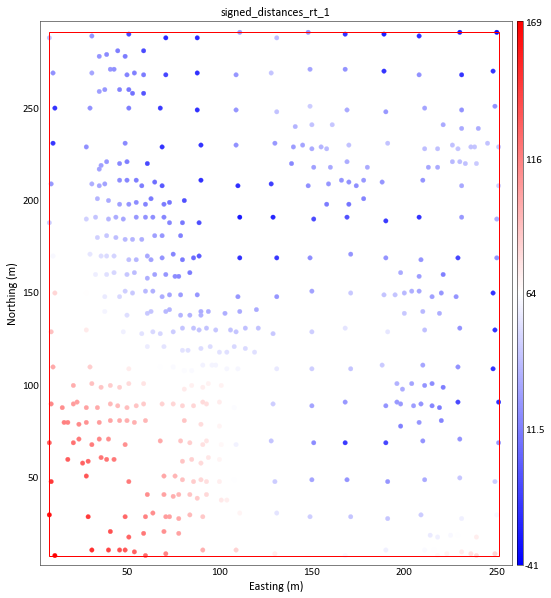

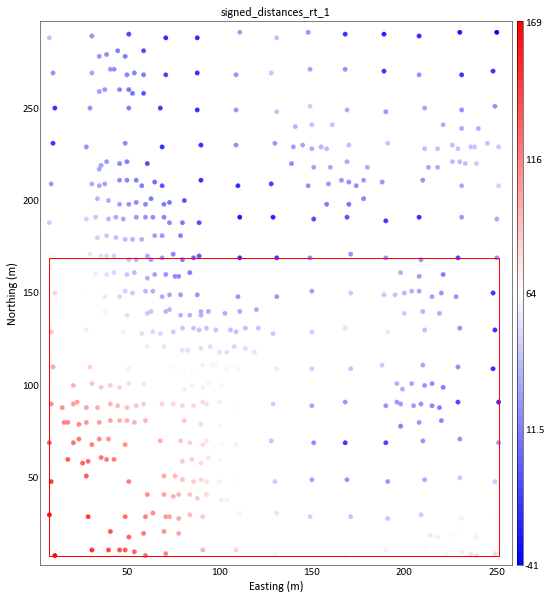

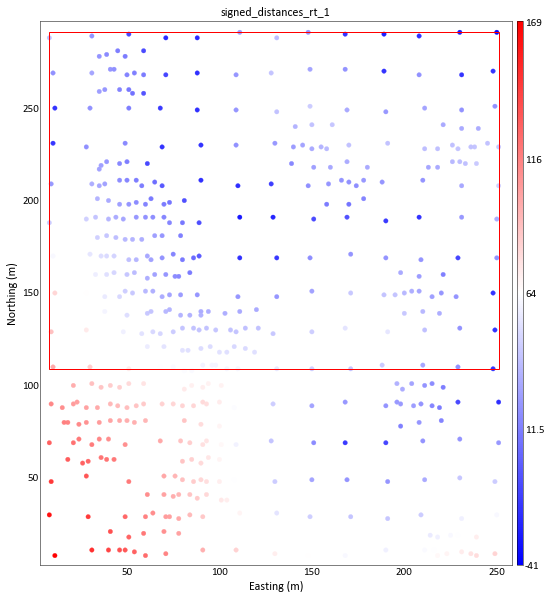

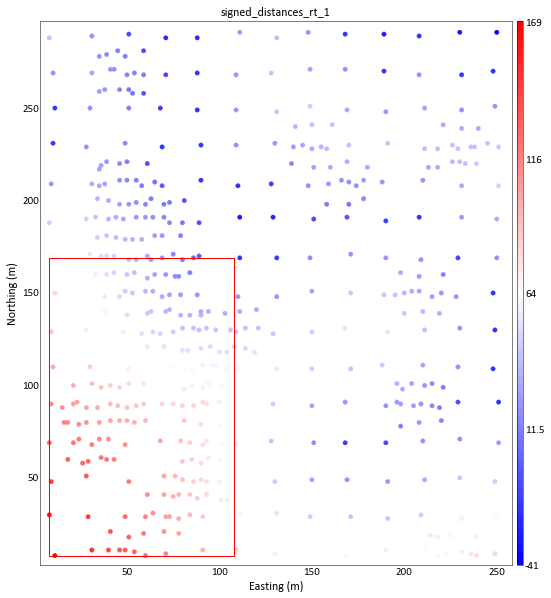

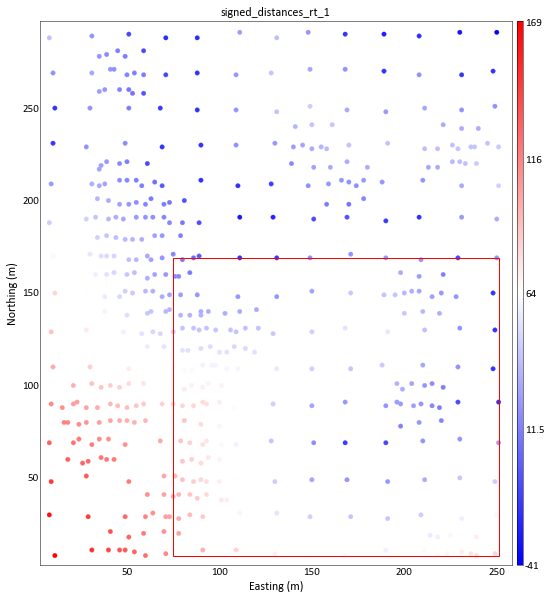

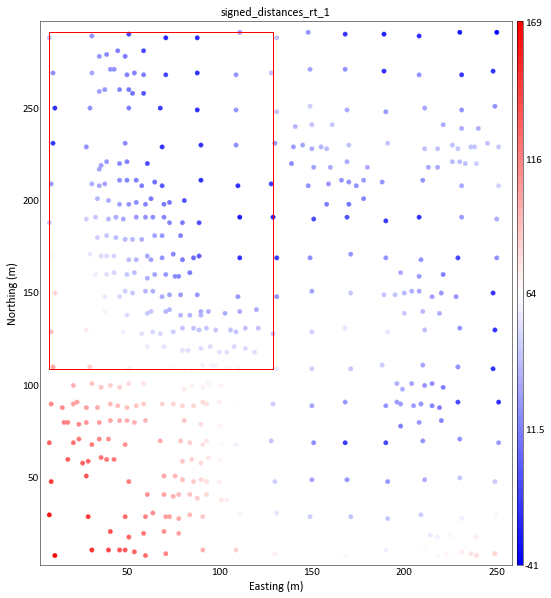

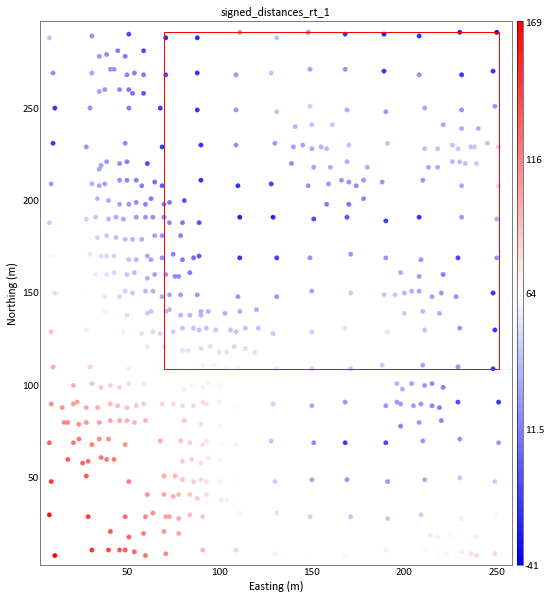

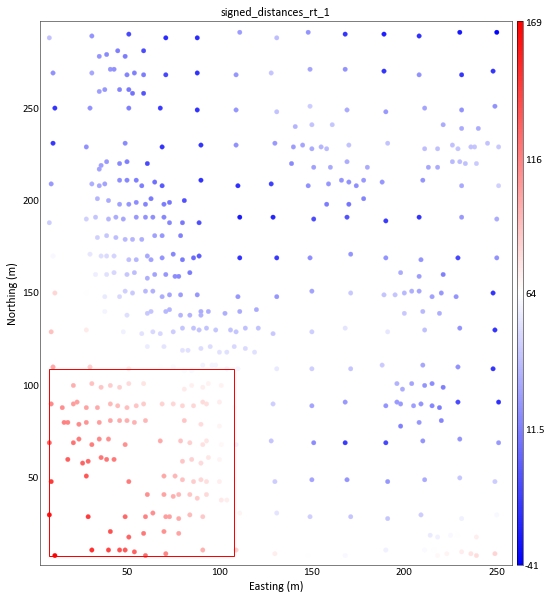

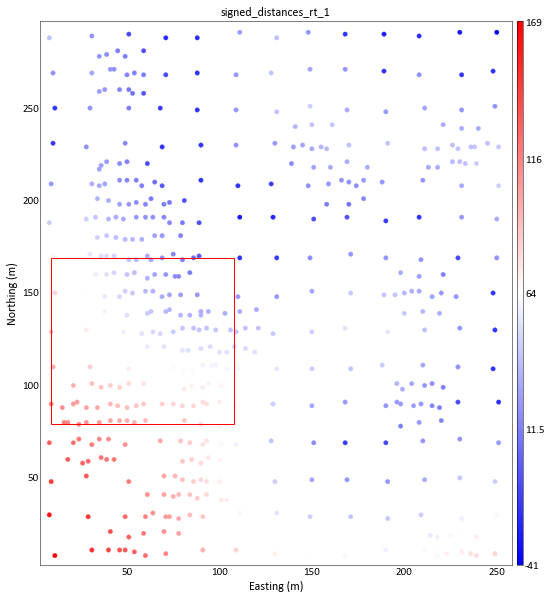

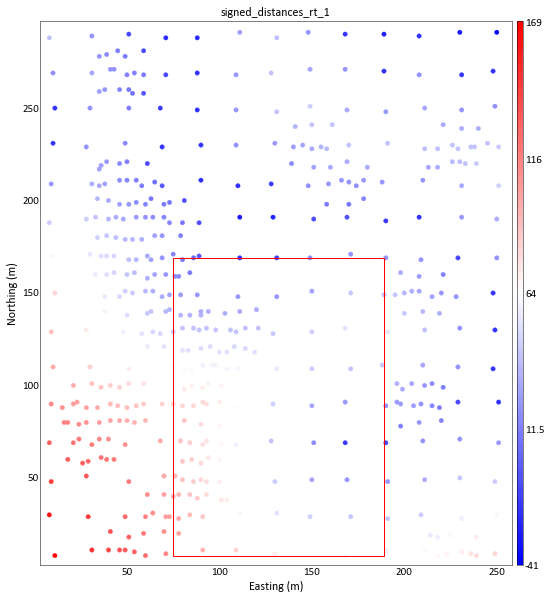

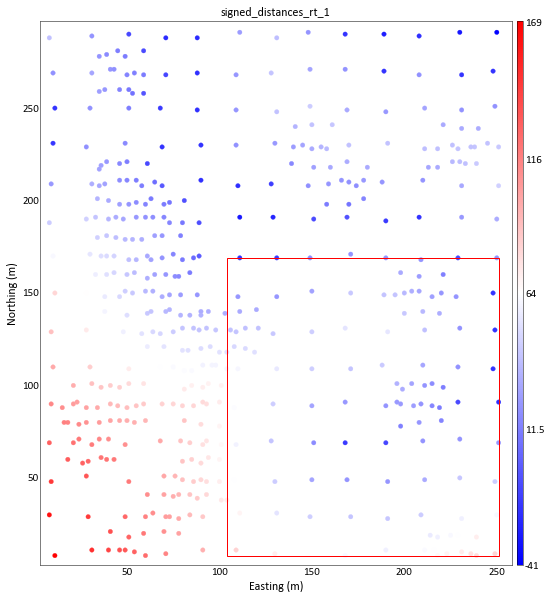

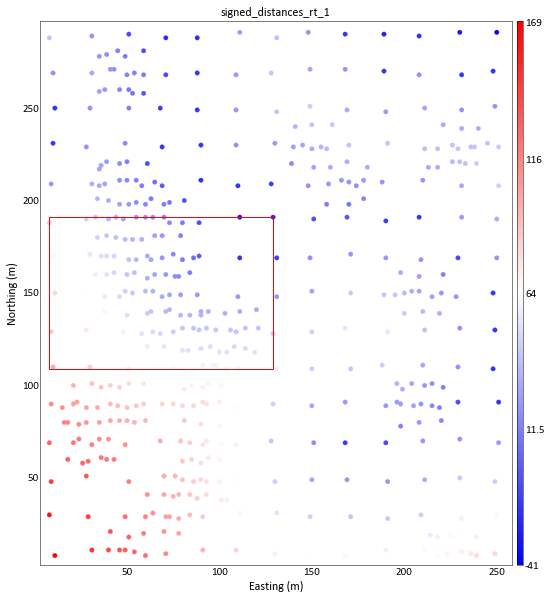

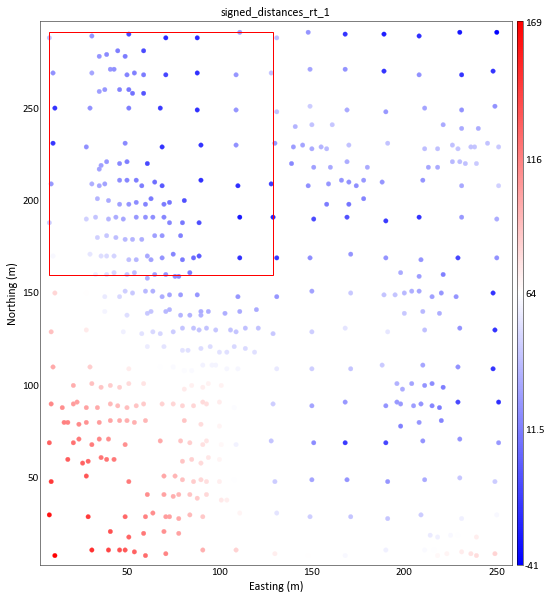

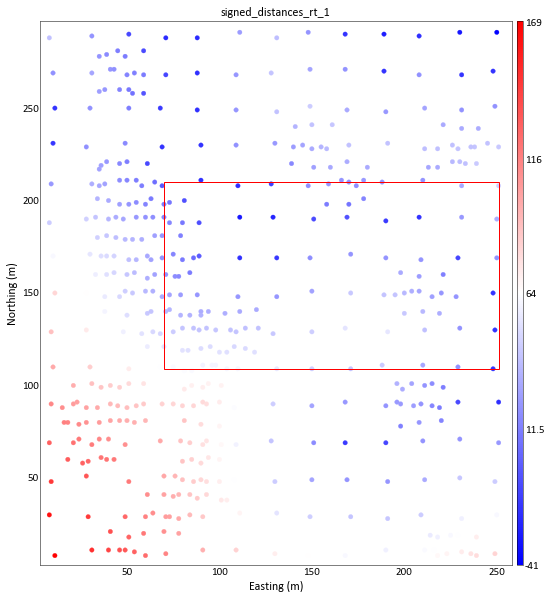

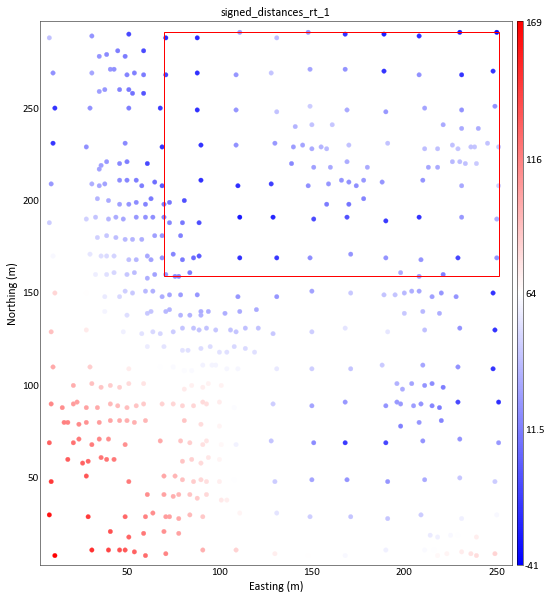

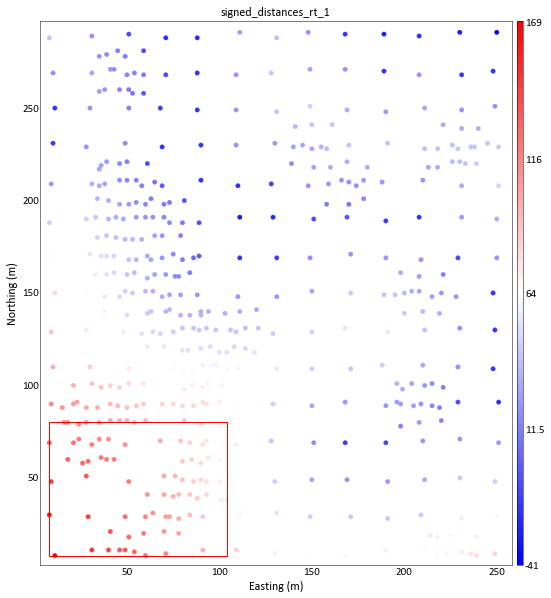

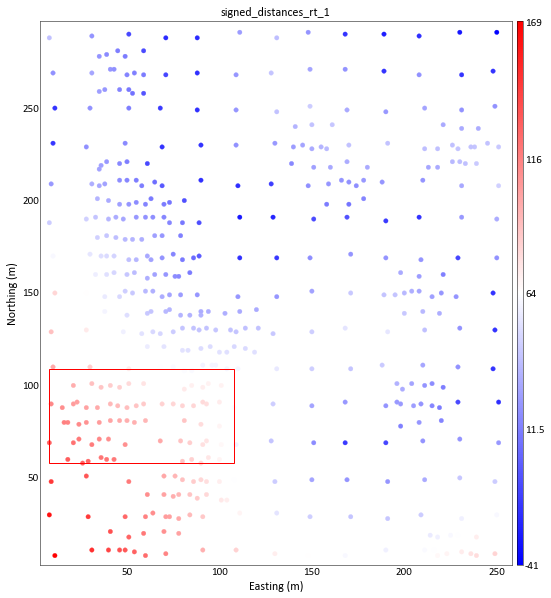

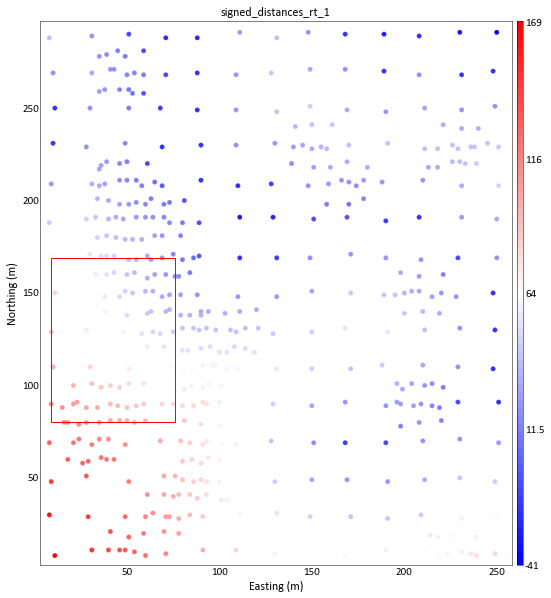

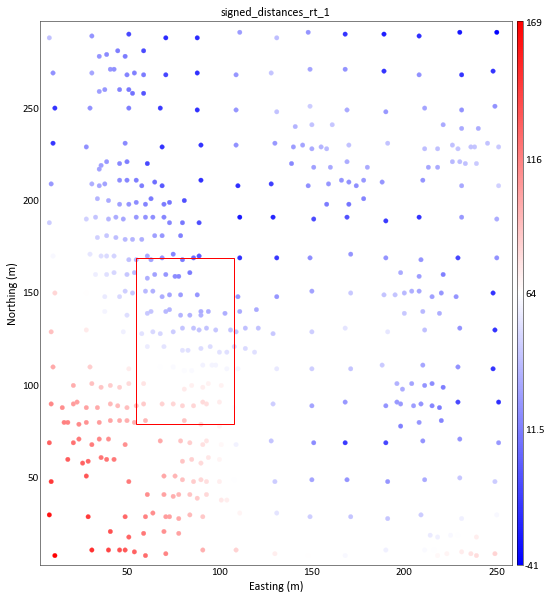

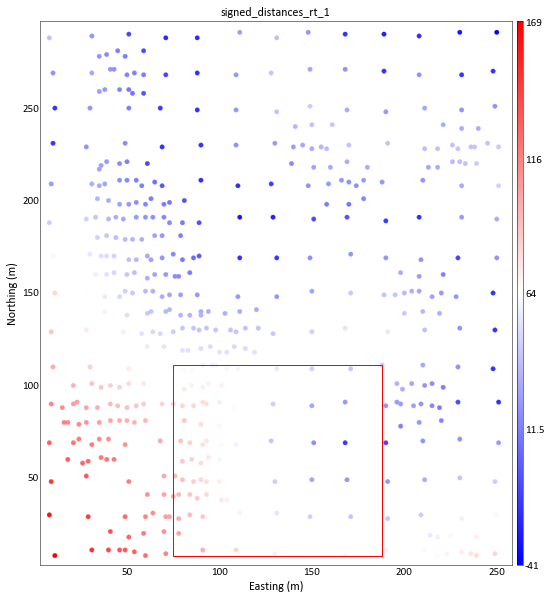

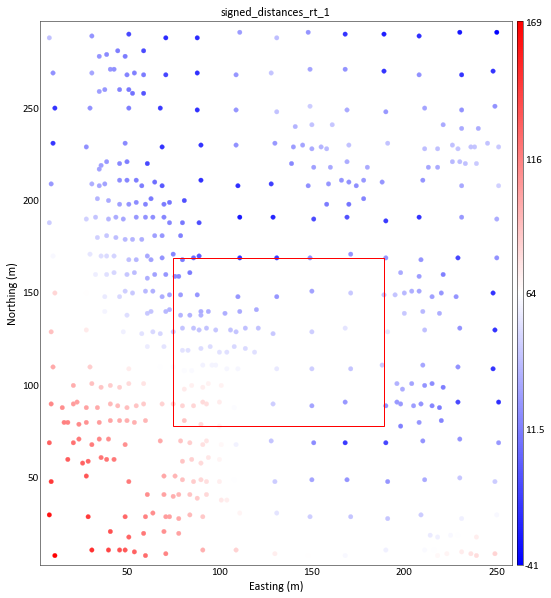

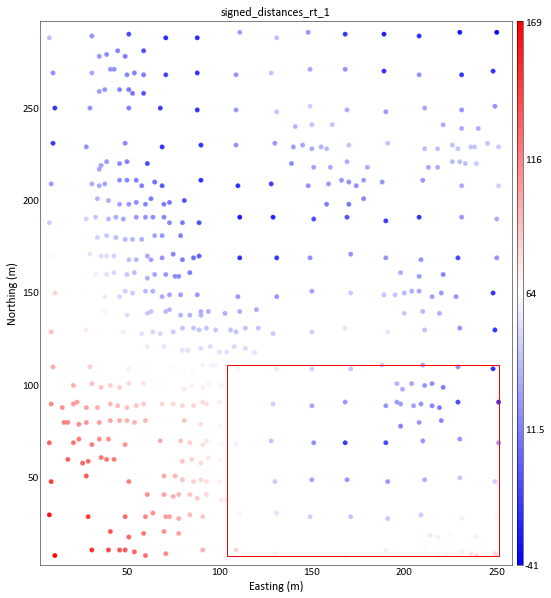

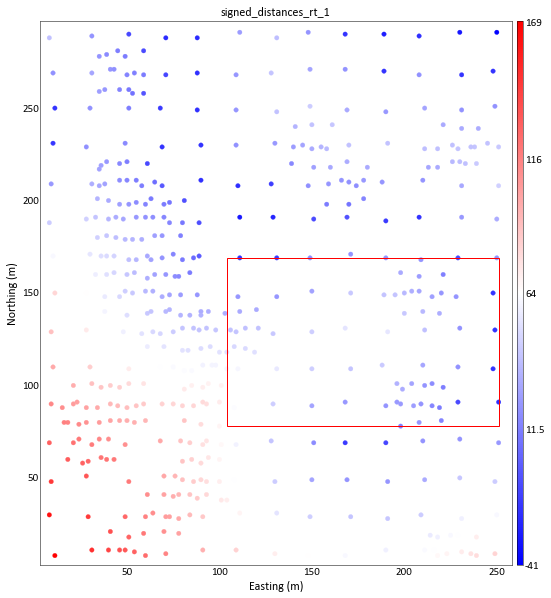

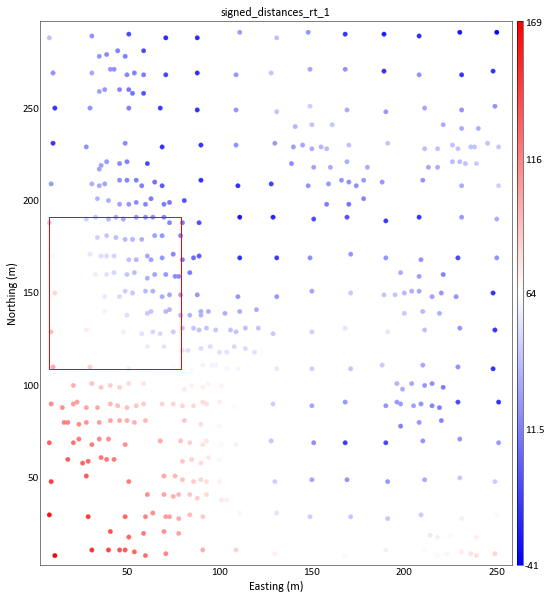

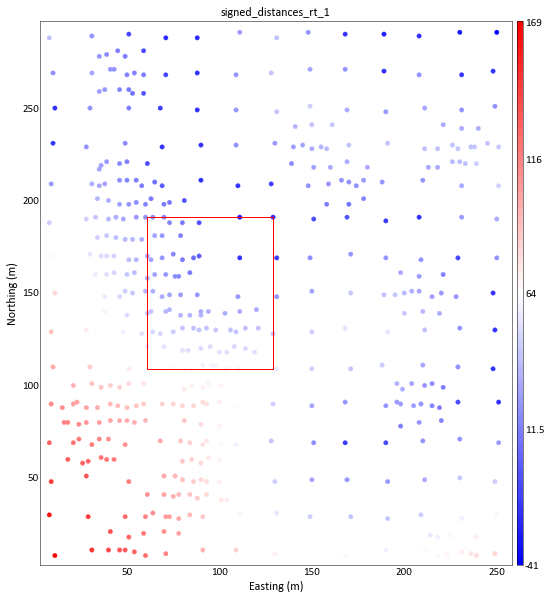

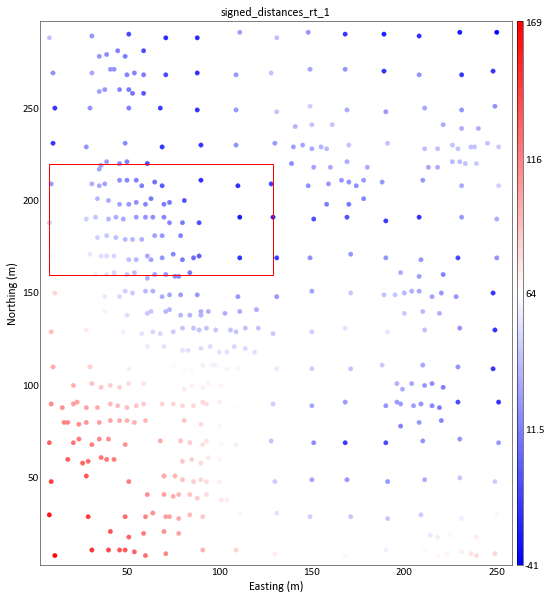

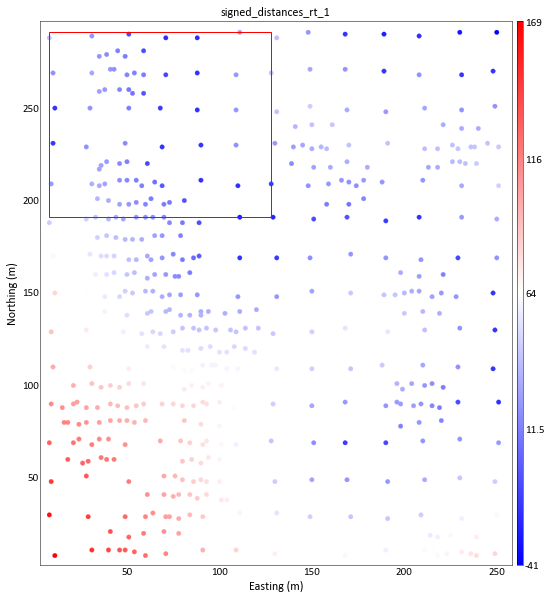

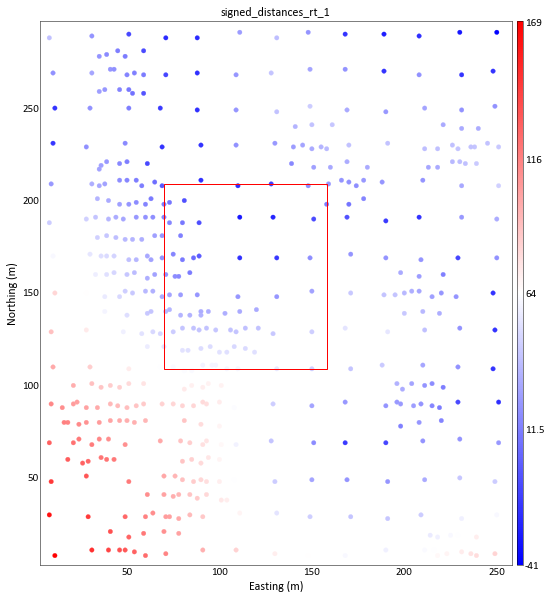

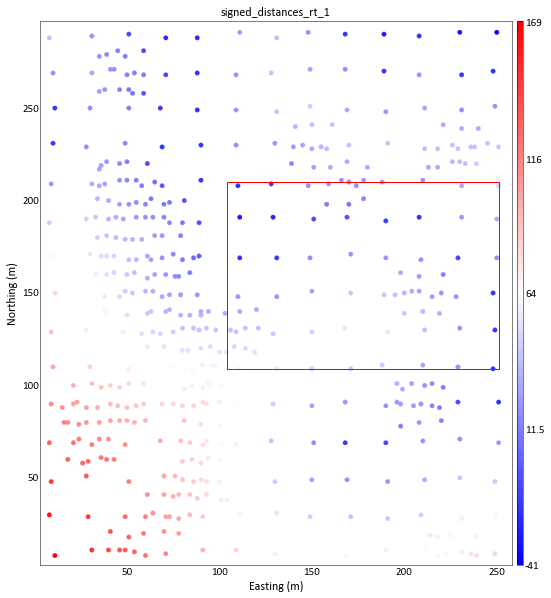

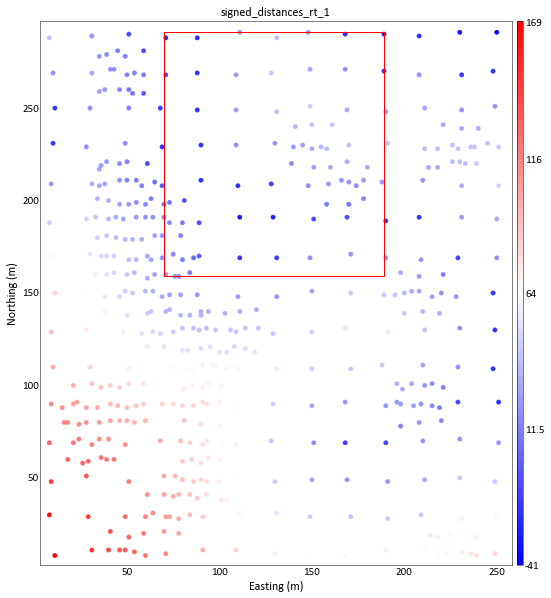

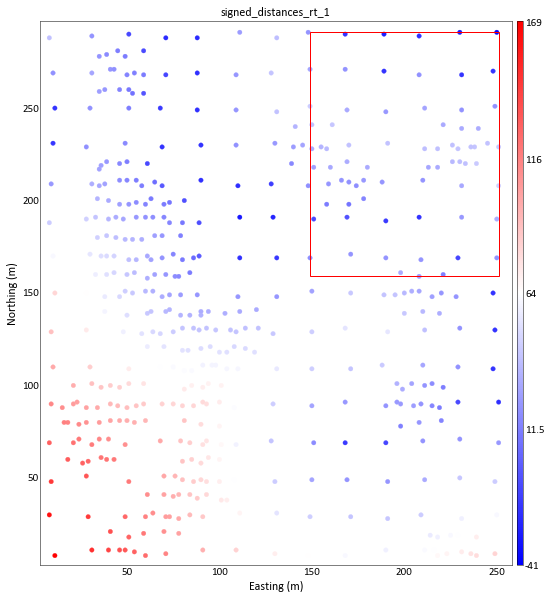

In [243]:
ptest.partition()

In [244]:
len(ptest.used_partitions)

16

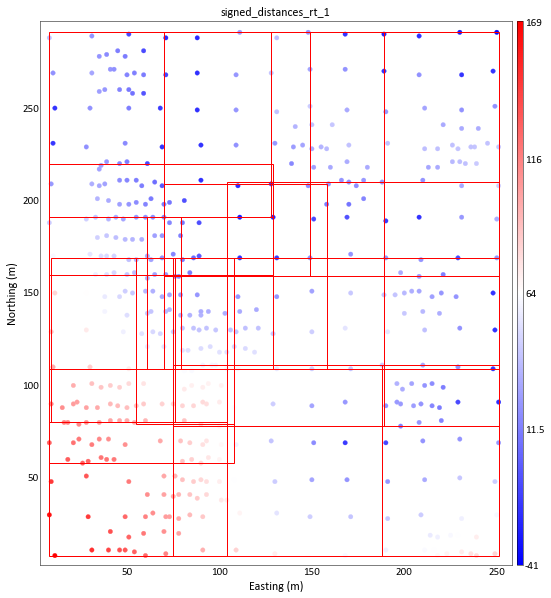

In [245]:
ups = ptest.uppers
lows = ptest.lowers

fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
for u, l in zip(ups, lows):

    rect1 = Rectangle((l[0], l[1]), u[0]-l[0], u[1]-l[1], linewidth=1, edgecolor='red', facecolor='none')
    axs.add_patch(rect1)

In [246]:
ptest.calculate_weights()

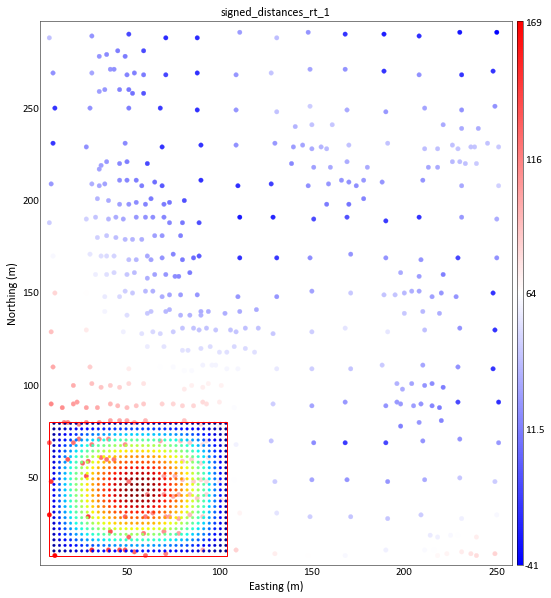

In [247]:
c=0
coords = np.array(ptest.grid_coords).T[ptest.grids_used[c]].T
x, y, z = coords[0], coords[1], coords[2]
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)
axs.scatter(x, y, s=7, c=ptest.weights[c], cmap='jet')

In [248]:
ptest.normalize_weights()

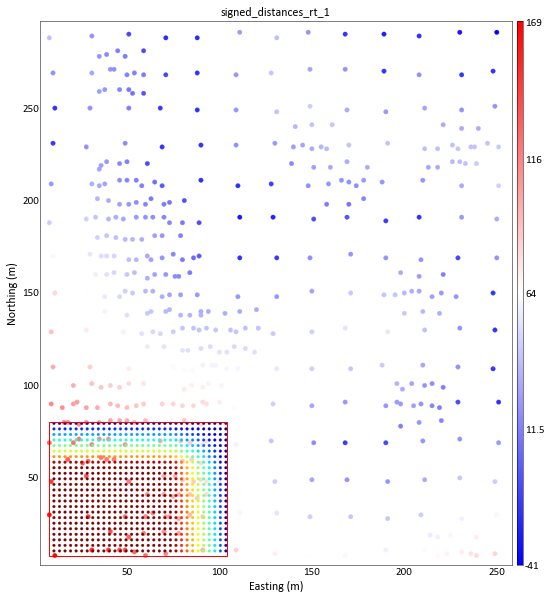

In [249]:
c=0
coords = np.array(ptest.grid_coords).T[ptest.grids_used[c]].T
x, y, z = coords[0], coords[1], coords[2]
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs)
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)
axs.scatter(x, y, s=7, c=ptest.norm_weights[c], cmap='jet')